In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "cs231n/project/"
assert FOLDERNAME is not None, "[!] Enter the foldername."
PROJECT_PATH = f"/content/drive/My Drive/{FOLDERNAME}"
sys.path.append(PROJECT_PATH)

# Change working directory
os.chdir(PROJECT_PATH)

# Confirm
print("✅ Current working directory:", os.getcwd())
print("📁 Contents:", os.listdir('.'))

Mounted at /content/drive
✅ Current working directory: /content/drive/My Drive/cs231n/project
📁 Contents: ['.ipynb_checkpoints', '__pycache__', 'patch_unet.py', 'obsolete', 'data', 'lora.py', 'lora_weights.pth', 'generated.png', 'backup_data', 'lora_sd_colab.ipynb']


# 💡 LoRA Training on Stable Diffusion
This notebook trains custom LoRA adapters on Stable Diffusion using your own image-caption pairs.


In [2]:
!pip install -q diffusers transformers accelerate torchvision safetensors

In [3]:
from lora import LoRALinear
from patch_unet import patch_unet_with_lora

## Data Preparation

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from diffusers import StableDiffusionPipeline
from patch_unet import patch_unet_with_lora

class ImageTextDataset(Dataset):
    def __init__(self, files):
        self.samples = []
        for name in files.keys():
            if name.endswith(".png") or name.endswith(".jpg"):
                txt = name.rsplit(".", 1)[0] + ".txt"
                if txt in files:
                    self.samples.append((name, txt))
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, txt_file = self.samples[idx]
        image = Image.open(img_file).convert("RGB")
        image = self.transform(image)
        caption = files[txt_file].decode()
        return image, caption


class ImageTextDataset(Dataset):
    def __init__(self, root_dir="data"):
        self.root_dir = root_dir
        self.samples = []
        for fname in os.listdir(root_dir):
            if fname.lower().endswith((".jpg", ".png")):
                basename = os.path.splitext(fname)[0]
                txt_path = os.path.join(root_dir, basename + ".txt")
                if os.path.exists(txt_path):
                    self.samples.append((os.path.join(root_dir, fname), txt_path))

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, txt_path = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        with open(txt_path, "r") as f:
            caption = f.read().strip()
        return image, caption


In [5]:
dataset = ImageTextDataset("data")
loader = DataLoader(dataset, batch_size=1, shuffle=True)
# sanity check for datasets
print(f"Number of image-caption pairs: {len(dataset)}")

Number of image-caption pairs: 84


In [6]:
# suppress warnings due to missing fonts.
import warnings
import re

# This regex will match messages containing "Glyph" and "missing from font"
warnings.filterwarnings("ignore", category=UserWarning, message=r"Glyph .* missing from font\(s\) DejaVu Sans\.")


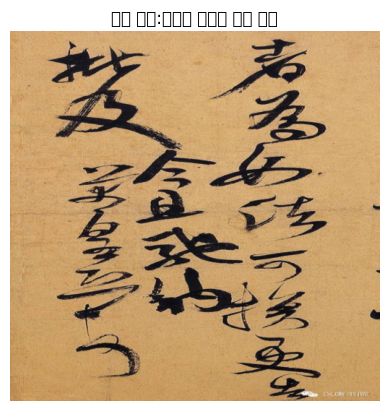

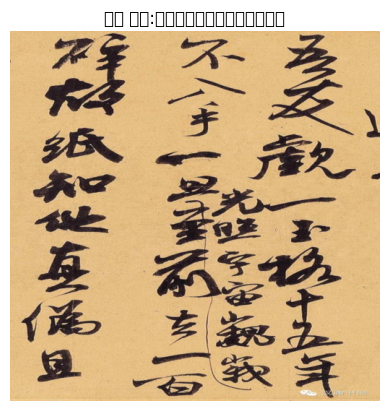

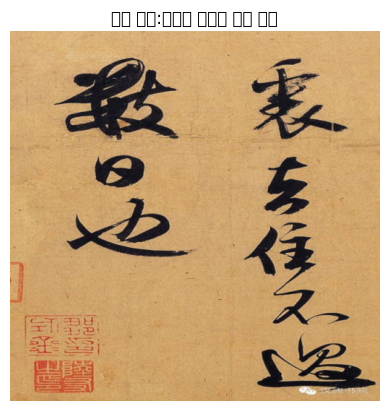

In [7]:
# preview a couple of images.
from matplotlib import pyplot as plt

for i in range(min(3, len(dataset))):  # Show up to 3 examples
    image, caption = dataset[i]
    plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Undo normalization
    plt.axis("off")
    plt.title(caption)
    plt.show()


## Training Logic for Lora Finetuning

In [8]:
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32).to(device)

pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.unet.requires_grad_(False)

# ADD LORA
patch_unet_with_lora(pipe.unet, r=4, alpha=1.0, dropout=0.0)
pipe.unet.to(device)  # Move after patching

# unfreeze lora weights
for module in pipe.unet.modules():
    if "LoRALinear" in str(type(module)):
        for p in module.parameters():
            p.requires_grad = True

optimizer = torch.optim.Adam([p for p in pipe.unet.parameters() if p.requires_grad], lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
# training
for epoch in range(10):
    for i, (images, captions) in enumerate(loader):
        # Keep images in float32
        images = images.to(device)

        text_input = pipe.tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt").to(device)
        text_embeds = pipe.text_encoder(**text_input).last_hidden_state.to(device)  # stays float32

        with torch.no_grad():
            vae_output = pipe.vae.encode(images)
        latents = vae_output.latent_dist.sample().to(device) * 0.18215  # float32

        noise = torch.randn_like(latents).to(device)  # float32 noise
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

        noise_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states=text_embeds).sample  # float32

        loss = nn.MSELoss()(noise_pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Epoch {epoch} Step {i} Loss: {loss.item():.4f}")

Epoch 0 Step 0 Loss: 0.0213
Epoch 0 Step 1 Loss: 0.3156
Epoch 0 Step 2 Loss: 0.2289
Epoch 0 Step 3 Loss: 0.0384
Epoch 0 Step 4 Loss: 0.1677
Epoch 0 Step 5 Loss: 0.2710
Epoch 0 Step 6 Loss: 0.0392
Epoch 0 Step 7 Loss: 0.0028
Epoch 0 Step 8 Loss: 0.2956
Epoch 0 Step 9 Loss: 0.0467
Epoch 0 Step 10 Loss: 0.0286
Epoch 0 Step 11 Loss: 0.0853
Epoch 0 Step 12 Loss: 0.1101
Epoch 0 Step 13 Loss: 0.0299
Epoch 0 Step 14 Loss: 0.1723
Epoch 0 Step 15 Loss: 0.0156
Epoch 0 Step 16 Loss: 0.0171
Epoch 0 Step 17 Loss: 0.0080
Epoch 0 Step 18 Loss: 0.0568
Epoch 0 Step 19 Loss: 0.0346
Epoch 0 Step 20 Loss: 0.1189
Epoch 0 Step 21 Loss: 0.0474
Epoch 0 Step 22 Loss: 0.0176
Epoch 0 Step 23 Loss: 0.0022
Epoch 0 Step 24 Loss: 0.0625
Epoch 0 Step 25 Loss: 0.1271
Epoch 0 Step 26 Loss: 0.0231
Epoch 0 Step 27 Loss: 0.2682
Epoch 0 Step 28 Loss: 0.2849
Epoch 0 Step 29 Loss: 0.3989
Epoch 0 Step 30 Loss: 0.1872
Epoch 0 Step 31 Loss: 0.2654
Epoch 0 Step 32 Loss: 0.1064
Epoch 0 Step 33 Loss: 0.4541
Epoch 0 Step 34 Loss: 0.

In [14]:
# save model parameters

torch.save(
    {k: v.cpu() for k, v in pipe.unet.state_dict().items() if "lora" in k},
    "lora_weights.pth"
)

## Generate images with Trained LoRA

  0%|          | 0/30 [00:00<?, ?it/s]

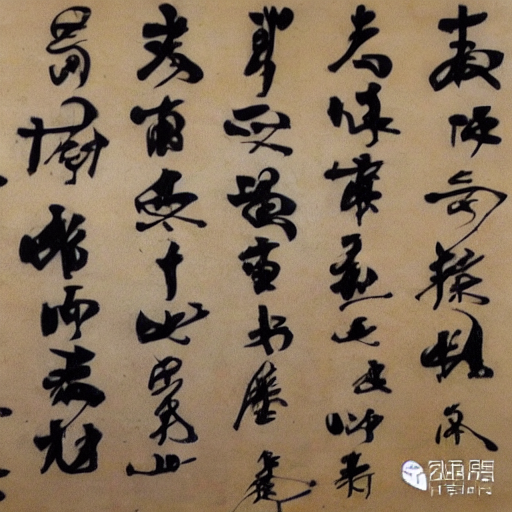

In [16]:
state_dict = torch.load("lora_weights.pth", map_location=device)
patch_unet_with_lora(pipe.unet, r=4, alpha=1.0)
pipe.unet.load_state_dict(state_dict, strict=False)
pipe.unet.eval()

prompt = "米芾"
image = pipe(prompt, num_inference_steps=30).images[0]
image.save("generated.png")
image.show()
display(image)   # shows inline in the notebook
